# Capstone Project - Predicting Smartphone Purchase of Multi Category Store
## Part 7 - Prediction of Smartphone Purchases by High-Value Customers

### Table of Contents

* [Section 1.  Import dataset](#section_1)
* [Section 2.  EDA and feature engineering](#section_2)
    * [2.1 Customer segregation](#section_2_a)
    * [2.2 Creat features](#section_2_b)
        * [2.2.1 Session features](#section_2_2_1)
        * [2.2.2 Customer features](#section_2_2_2)
        * [2.2.3 Customer on product features](#section_2_2_3)
* [Section 3. Modelling](#section_3)
    * [3.1 Pipeline](#section_3_a)
    * [3.2 Prediction](#section_3_b)
        * [3.2.1 Logistic regression](#section_3_2_1)
        * [3.2.2 Ridge classifier](#section_3_2_2)
        * [3.2.3 Gradient boosting classifier](#section_3_2_3)
        * [3.2.4 XG boost classifier](#section_3_2_4)
    * [3.3 Summary](#section_3_c)


## Section 1.  Import dataset <a class="anchor" id="section_1"></a> 
import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

In [2]:
column_name_and_dtype = {'event_type': 'category',
                         'product_id': 'category',
                         'category_id': 'category',
                         'category_code': 'category',
                         'brand': 'category',
                         'user_id': 'category',
                         'user_session': 'category',
                         'views': 'int8',
                         'carts': 'int8',
                         'sales': 'int8',
                        }


In [3]:
%%time
df = pd.read_csv('csv_files/dataset.gz', 
                 compression = 'gzip', 
                 low_memory = True, 
                 dtype = column_name_and_dtype,
                 parse_dates = ['event_time'])


Wall time: 9min 3s


In [3]:
#df['category'] = df['category_code'].apply(lambda x: x.split('.')[0])
#df['product'] = df['category_code'].apply(lambda x: x.split('.')[-1])
#df['revenue'] = df['price'] * df['sales']

''

In [5]:
df.head(5)

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,views,carts,sales,week_id,category,product,revenue
0,2019-10-01 00:00:00+00:00,view,3900821,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,1,0,0,40,appliances,water_heater,0.0
1,2019-10-01 00:00:01+00:00,view,1307067,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,1,0,0,40,computers,notebook,0.0
2,2019-10-01 00:00:04+00:00,view,1004237,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1,0,0,40,electronics,smartphone,0.0
3,2019-10-01 00:00:05+00:00,view,1480613,computers.desktop,pulser,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,1,0,0,40,computers,desktop,0.0
4,2019-10-01 00:00:10+00:00,view,28719074,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,1,0,0,40,apparel,keds,0.0


extract dataset for smartphone products

In [6]:
df_phone = df[df['product']=='smartphone']

instances associated with smartphone products account for up to 40.6% of total instances!

In [7]:
df.shape, df_phone.shape

((68650184, 15), (27838899, 15))

delete the complete dataset to free up memory

In [8]:
del df
gc.collect()

66

In [10]:
%%time
df_phone.to_csv('csv_files/phone_dataset.csv', index = False)

Wall time: 5min 48s


## Section 2.  EDA and feature engineering <a class="anchor" id="section_2"></a> 


In [4]:
df_phone_org = pd.read_csv('csv_files/phone_dataset.csv',
                           parse_dates = ['event_time'])


In [12]:
df_phone_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27838899 entries, 0 to 27838898
Data columns (total 15 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_code  object             
 4   brand          object             
 5   price          float64            
 6   user_id        int64              
 7   user_session   object             
 8   views          int64              
 9   carts          int64              
 10  sales          int64              
 11  week_id        int64              
 12  category       object             
 13  product        object             
 14  revenue        float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(6), object(6)
memory usage: 3.1+ GB


Check out the number of users and number of smartphone products in the dataset

In [14]:
df_phone_org['user_id'].nunique(), df_phone_org['product_id'].nunique()

(2438160, 1358)

### Section 2.1  Customer segregation <a class="anchor" id="section_2_a"></a> 


In [5]:
grouped = df_phone_org.groupby(['user_id'])['revenue'].sum().reset_index()
grouped.sort_values(by = 'revenue', ascending = True, inplace = True)
#grouped['label'] = pd.qcut(grouped['revenue'],  [0, .25, .75, 1.], labels=["bronze", "silver", "gold"])
#grouped['label'] = pd.qcut(grouped['revenue'],  4, labels=["bronze", "silver", "silver", "gold"])
#grouped['label'].value_counts()

In [16]:
grouped.shape, grouped[grouped['revenue']>0].shape

((2438160, 3), (321917, 3))

In [6]:
phone_revenue = grouped['revenue'].sum()
grouped['pct_cumsum'] = grouped['revenue'].cumsum() / phone_revenue

In [15]:
grouped.tail(10)

,user_id,revenue,pct_cumsum
765455,530834332,168781.35,0.994300
1301387,553431815,169541.43,0.994807
491883,519250600,169824.39,0.995314
299715,515715331,173027.52,0.995832
797161,532499743,175600.43,0.996357
831688,534545940,183309.03,0.996905
443832,518514099,202658.64,0.997511
97615,513117637,264989.07,0.998303
493341,519267944,265410.22,0.999096
276958,515384420,302305.68,1.000000


In [10]:
grouped[grouped['pct_cumsum'] > 0.85].shape

(2096, 3)

In [156]:
#df_phone[(df_phone['user_id']=='515384420') & (df_phone['sales']>0)]

Select the top customers with an aggregated revenue contribution of 15% 

In [17]:
list_user_id = list(grouped[grouped['pct_cumsum'] > 0.85]['user_id'])

In [19]:
df_phone = df_phone_org[df_phone_org['user_id'].isin(list_user_id)]
df_phone.shape

(369137, 15)

In [20]:
df_phone['user_id'].nunique(), df_phone['product_id'].nunique()

(2096, 898)

### Section 2.2  Creat features <a class="anchor" id="section_2_b"></a> 


In [21]:
df_session = df_phone.groupby(['user_session']) \
                     .agg(time_start = ('event_time', 'min'),
                          time_end = ('event_time', 'max'),
                         ) \
                     .reset_index()

df_session.dropna(how='any', inplace = True)


In [22]:
df_session['session_duration'] = (df_session['time_end'] - df_session['time_start']).dt.total_seconds().astype('int')

In [23]:
df_session.head()

,user_session,time_start,time_end,session_duration
0,00007879-7a3c-4e0b-87a1-237ec203b27c,2019-11-16 04:49:47+00:00,2019-11-16 04:49:55+00:00,8
1,000174ac-0ea3-4026-8dfd-cd0bed476450,2019-10-18 10:44:59+00:00,2019-10-18 10:46:54+00:00,115
2,0002534e-e8a2-46d6-9f4a-b2ec4f1a061a,2019-10-15 06:28:53+00:00,2019-10-15 06:29:33+00:00,40
3,0005a967-3c02-459f-9173-4dafcaeecdf1,2019-11-03 16:39:03+00:00,2019-11-03 16:40:30+00:00,87
4,000891bc-8f32-4d57-90e8-f80cb54be2e2,2019-10-03 13:15:18+00:00,2019-10-03 13:19:07+00:00,229


Filter sessions with session duration less than 1 hour

In [24]:
df_session = df_session[df_session['session_duration'] < 3600]

In [25]:
session_list = list(df_session['user_session'].unique())

In [26]:
df_sales = df_phone[df_phone['user_session'].isin(session_list)]

In [27]:
df_sales.reset_index(drop = True, inplace = True)

In [28]:
df_sales['user_id'].nunique(), df_sales['product_id'].nunique()

(2096, 896)

In [29]:
#df_sales.loc[:,'weekday'] = df_sales['event_time'].dt.weekday.astype('int8')
#df_sales.loc[:,'hour'] = df_sales['event_time'].dt.hour.astype('int8')

Create new user id (uid), product id (pid) and sessionn id (sid) to accelerate computation

In [30]:
user_dict = dict(zip(list(df_sales['user_id'].unique()),np.arange(df_sales['user_id'].nunique())))
product_dict = dict(zip(list(df_sales['product_id'].unique()),np.arange(df_sales['product_id'].nunique())))
session_dict = dict(zip(list(df_sales['user_session'].unique()),np.arange(df_sales['user_session'].nunique())))


In [31]:
df_sales.loc[:,'uid'] = df_sales['user_id'].map(user_dict).astype('int')
df_sales.loc[:,'pid'] = df_sales['product_id'].map(product_dict).astype('int')
df_sales.loc[:,'sid'] = df_sales['user_session'].map(session_dict).astype('int')


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### Section 2.2.1  Session features <a class="anchor" id="section_2_2_1"></a> 


In [32]:
df_session = df_sales.groupby(['uid', 'sid', 'week_id']) \
                     .agg(is_cart = ('carts', 'max'),
                          is_purchased = ('sales', 'max'),
                         ) \
                     .reset_index()


In [33]:
df_session.sample(5)

,uid,sid,week_id,is_cart,is_purchased
21282,500,24920,43,0,1
15583,369,47883,46,0,0
17022,409,53376,46,1,0
18867,448,19701,42,1,1
32689,807,16626,42,1,1


In [34]:
grouped = df_session.groupby(['uid', 'week_id']) \
                    .agg(total_sessions = ('sid', 'nunique'),
                         cart_sessions = ('is_cart', 'sum'),
                         sale_sessions = ('is_purchased', 'sum'),
                        ) \
                    .reset_index()

In [35]:
grouped

,uid,week_id,total_sessions,cart_sessions,sale_sessions
0,0,40,46,2,37
1,1,40,4,3,3
2,1,41,5,4,5
3,1,42,1,1,0
4,2,40,3,1,2
...,...,...,...,...,...
11785,2091,48,10,9,9
11786,2092,48,11,11,10
11787,2093,48,9,8,7
11788,2094,48,10,8,7


In [36]:
col = 'total_sessions'
col_last1w = col + '_last_1w'
col_cumsum = col + '_cumsum'

df_last1w = pd.pivot_table(grouped, values=col, index = 'uid', columns='week_id', fill_value=0)
df_cumsum = df_last1w.cumsum(axis = 1)

df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'uid', value_name = col)
df_last1w.rename(columns = {col: col_last1w}, inplace = True)

df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'uid', value_name = col)
df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

df_sid = pd.merge(df_last1w, df_cumsum, on = ['uid','week_id'])

col = 'cart_sessions'
col_last1w = col + '_last_1w'
col_cumsum = col + '_cumsum'

df_last1w = pd.pivot_table(grouped, values=col, index = 'uid', columns='week_id', fill_value=0)
df_cumsum = df_last1w.cumsum(axis = 1)

df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'uid', value_name = col)
df_last1w.rename(columns = {col: col_last1w}, inplace = True)

df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'uid', value_name = col)
df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

df_sid = pd.merge(df_sid, df_last1w, on = ['uid','week_id'])
df_sid = pd.merge(df_sid, df_cumsum, on = ['uid','week_id'])
df_sid

col = 'sale_sessions'
col_last1w = col + '_last_1w'
col_cumsum = col + '_cumsum'

df_last1w = pd.pivot_table(grouped, values=col, index = 'uid', columns='week_id', fill_value=0)
df_cumsum = df_last1w.cumsum(axis = 1)

df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'uid', value_name = col)
df_last1w.rename(columns = {col: col_last1w}, inplace = True)

df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'uid', value_name = col)
df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

df_sid = pd.merge(df_sid, df_last1w, on = ['uid','week_id'])
df_sid = pd.merge(df_sid, df_cumsum, on = ['uid','week_id'])
df_sid


,uid,week_id,total_sessions_last_1w,total_sessions_cumsum,cart_sessions_last_1w,cart_sessions_cumsum,sale_sessions_last_1w,sale_sessions_cumsum
0,0,40,46,46,2,2,37,37
1,1,40,4,4,3,3,3,3
2,2,40,3,3,1,1,2,2
3,3,40,3,3,1,1,1,1
4,4,40,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...
18859,2091,48,10,10,9,9,9,9
18860,2092,48,11,11,11,11,10,10
18861,2093,48,9,9,8,8,7,7
18862,2094,48,10,10,8,8,7,7


In [37]:
df_sid.loc[:,'week_id'] = df_sid['week_id'] - 1
#df_sid = df_sid[df_sid['week_id'] > week_id_min]


Merge session features into dataset

In [38]:
df_cspw   = df_sales.groupby(['uid', 'sid', 'pid', 'week_id']) \
                     .agg(event_time = ('event_time', 'first'),
                          product_id = ('product_id', 'first'),
                          brand = ('brand', 'first'),
                          views = ('views', 'sum'),
#                          carts = ('carts', 'sum'),
#                          sales = ('sales', 'sum'),
                          is_cart = ('carts', 'max'),
                          is_purchased = ('sales', 'max'),
                          ) \
                     .reset_index()


In [39]:
df_cspw = df_cspw.merge(df_sid, how = 'left', on = ['uid','week_id'])
df_cspw.sample(5)

,uid,sid,pid,week_id,event_time,product_id,brand,views,is_cart,is_purchased,total_sessions_last_1w,total_sessions_cumsum,cart_sessions_last_1w,cart_sessions_cumsum,sale_sessions_last_1w,sale_sessions_cumsum
79015,1204,20436,67,42,2019-10-18 17:35:19+00:00,1004767,samsung,1,1,1,1.0,16.0,0.0,10.0,0.0,9.0
743,14,5889,59,41,2019-10-07 10:03:42+00:00,1005106,apple,1,0,0,14.0,39.0,2.0,3.0,5.0,11.0
108066,1753,28429,59,43,2019-10-25 22:30:24+00:00,1005106,apple,1,0,0,7.0,13.0,2.0,5.0,3.0,5.0
36979,506,30635,14,44,2019-10-28 04:21:02+00:00,1004237,apple,2,0,1,14.0,94.0,10.0,52.0,13.0,84.0
78143,1187,36071,109,44,2019-11-01 20:06:46+00:00,1004834,samsung,1,0,0,1.0,9.0,0.0,4.0,0.0,4.0


#### Section 2.2.2  Customer features <a class="anchor" id="section_2_2_2"></a> 


In [40]:
df_counts  = df_sales.groupby(['uid', 'week_id']) \
                     .agg(views = ('views', 'sum'),
                          carts = ('carts', 'sum'),
                          sales = ('sales', 'sum'),
                          revenue = ('revenue', 'sum')) \
                     .reset_index()
df_counts.sample(5)

,uid,week_id,views,carts,sales,revenue
830,120,41,2,0,1,1003.85
4099,621,47,24,9,4,3172.23
5776,873,44,5,0,2,3003.63
9260,1458,42,28,2,1,229.99
7092,1076,44,28,1,5,4166.49


In [41]:
col = 'views'
col_last1w = 'u_' + col + '_last_1w'
col_cumsum = 'u_' + col + '_cumsum'

df_last1w = pd.pivot_table(df_counts, values=col, index = 'uid', columns='week_id', fill_value=0)
df_cumsum = df_last1w.cumsum(axis = 1)

df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'uid', value_name = col)
df_last1w.rename(columns = {col: col_last1w}, inplace = True)

df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'uid', value_name = col)
df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

df_uid = pd.merge(df_last1w, df_cumsum, on = ['uid','week_id'])

col = 'carts'
col_last1w = 'u_' + col + '_last_1w'
col_cumsum = 'u_' + col + '_cumsum'

df_last1w = pd.pivot_table(df_counts, values=col, index = 'uid', columns='week_id', fill_value=0)
df_cumsum = df_last1w.cumsum(axis = 1)

df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'uid', value_name = col)
df_last1w.rename(columns = {col: col_last1w}, inplace = True)

df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'uid', value_name = col)
df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

df_uid = pd.merge(df_uid, df_last1w, on = ['uid','week_id'])
df_uid = pd.merge(df_uid, df_cumsum, on = ['uid','week_id'])
df_uid

col = 'sales'
col_last1w = 'u_' + col + '_last_1w'
col_cumsum = 'u_' + col + '_cumsum'

df_last1w = pd.pivot_table(df_counts, values=col, index = 'uid', columns='week_id', fill_value=0)
df_cumsum = df_last1w.cumsum(axis = 1)

df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'uid', value_name = col)
df_last1w.rename(columns = {col: col_last1w}, inplace = True)

df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'uid', value_name = col)
df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

df_uid = pd.merge(df_uid, df_last1w, on = ['uid','week_id'])
df_uid = pd.merge(df_uid, df_cumsum, on = ['uid','week_id'])
df_uid

col = 'revenue'
col_last1w = 'u_' + col + '_last_1w'
col_cumsum = 'u_' + col + '_cumsum'

df_last1w = pd.pivot_table(df_counts, values=col, index = 'uid', columns='week_id', fill_value=0)
df_cumsum = df_last1w.cumsum(axis = 1)

df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'uid', value_name = col)
df_last1w.rename(columns = {col: col_last1w}, inplace = True)

df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'uid', value_name = col)
df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

df_uid = pd.merge(df_uid, df_last1w, on = ['uid','week_id'])
df_uid = pd.merge(df_uid, df_cumsum, on = ['uid','week_id'])
df_uid

,uid,week_id,u_views_last_1w,u_views_cumsum,u_carts_last_1w,u_carts_cumsum,u_sales_last_1w,u_sales_cumsum,u_revenue_last_1w,u_revenue_cumsum
0,0,40,90,90,2,2,42,42,18046.45,18046.45
1,1,40,13,13,8,8,6,6,7352.87,7352.87
2,2,40,26,26,1,1,2,2,1951.14,1951.14
3,3,40,4,4,1,1,1,1,1747.79,1747.79
4,4,40,10,10,7,7,5,5,8738.95,8738.95
...,...,...,...,...,...,...,...,...,...,...
18859,2091,48,65,65,38,38,37,37,29544.11,29544.11
18860,2092,48,98,98,17,17,11,11,15879.37,15879.37
18861,2093,48,19,19,13,13,10,10,13740.50,13740.50
18862,2094,48,39,39,16,16,15,15,12428.76,12428.76


Merge customer features into dataset

In [42]:
df_uid.loc[:,'week_id'] = df_uid['week_id'] - 1
#df_uid = df_uid[df_uid['week_id'] > week_id_min]
df_uid.loc[:,'r_u_carts_last_1w'] = df_uid['u_carts_last_1w'] / df_uid['u_views_last_1w']
df_uid.loc[:,'r_u_carts_cumsum'] = df_uid['u_carts_cumsum'] / df_uid['u_views_cumsum']
df_uid.loc[:,'r_u_sales_last_1w'] = df_uid['u_sales_last_1w'] / df_uid['u_views_last_1w']
df_uid.loc[:,'r_u_sales_cumsum'] = df_uid['u_sales_cumsum'] / df_uid['u_views_cumsum']

df_cspw = df_cspw.merge(df_uid.fillna(0), how = 'left', on = ['uid','week_id'])
df_cspw.sample(5)

,uid,sid,pid,week_id,event_time,product_id,brand,views,is_cart,is_purchased,...,u_carts_last_1w,u_carts_cumsum,u_sales_last_1w,u_sales_cumsum,u_revenue_last_1w,u_revenue_cumsum,r_u_carts_last_1w,r_u_carts_cumsum,r_u_sales_last_1w,r_u_sales_cumsum
67216,991,21669,21,42,2019-10-20 03:11:50+00:00,1005112,apple,4,1,1,...,0.0,8.0,1.0,21.0,999.23,19313.85,0.000000,0.123077,1.000000,0.323077
67206,991,10281,10,41,2019-10-11 10:03:54+00:00,1004258,apple,1,0,1,...,5.0,8.0,6.0,20.0,5789.53,18314.62,0.227273,0.125000,0.272727,0.312500
112522,1833,37519,5,44,2019-11-03 09:04:57+00:00,1004241,apple,2,0,1,...,13.0,13.0,17.0,26.0,28006.17,41965.12,0.393939,0.158537,0.515152,0.317073
50514,701,17600,51,42,2019-10-16 18:48:57+00:00,1003317,apple,2,0,0,...,0.0,17.0,0.0,18.0,0.00,12562.61,0.000000,0.130769,0.000000,0.138462
102547,1634,69598,464,48,2019-11-29 10:50:46+00:00,1005179,samsung,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Section 2.2.3  Customer on product features <a class="anchor" id="section_2_2_3"></a> 


In [43]:
df_counts  = df_sales.groupby(['uid', 'pid', 'week_id']) \
                     .agg(views = ('views', 'sum'),
                          carts = ('carts', 'sum'),
                          sales = ('sales', 'sum')) \
                     .reset_index()
df_counts.sample(5)

,uid,pid,week_id,views,carts,sales
29003,767,81,40,1,0,0
19931,518,28,40,2,1,1
53110,1538,2,45,1,0,0
56822,1653,97,44,1,1,1
12289,318,659,46,3,0,0


In [44]:
df_up = pd.DataFrame()

#for uid in [12]:
for uid in df_counts['uid'].unique():
    df = df_counts[df_counts['uid']==uid]
    col = 'views'
    col_last1w = 'up_' + col + '_last_1w'
    col_cumsum = 'up_' + col + '_cumsum'

    df_last1w = pd.pivot_table(df, values=col, index = 'pid', columns='week_id', fill_value=0)
    df_cumsum = df_last1w.cumsum(axis = 1)

    df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'pid', value_name = col)
    df_last1w.rename(columns = {col: col_last1w}, inplace = True)

    df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'pid', value_name = col)
    df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

    df_pid = pd.merge(df_last1w, df_cumsum, on = ['pid','week_id'])
    
    col = 'carts'
    col_last1w = 'up_' + col + '_last_1w'
    col_cumsum = 'up_' + col + '_cumsum'

    df_last1w = pd.pivot_table(df, values=col, index = 'pid', columns='week_id', fill_value=0)
    df_cumsum = df_last1w.cumsum(axis = 1)

    df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'pid', value_name = col)
    df_last1w.rename(columns = {col: col_last1w}, inplace = True)

    df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'pid', value_name = col)
    df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

    df_pid = pd.merge(df_pid, df_last1w, on = ['pid','week_id'])
    df_pid = pd.merge(df_pid, df_cumsum, on = ['pid','week_id'])
    
    col = 'sales'
    col_last1w = 'up_' + col + '_last_1w'
    col_cumsum = 'up_' + col + '_cumsum'

    df_last1w = pd.pivot_table(df, values=col, index = 'pid', columns='week_id', fill_value=0)
    df_cumsum = df_last1w.cumsum(axis = 1)

    df_last1w = pd.melt(df_last1w.reset_index(), id_vars = 'pid', value_name = col)
    df_last1w.rename(columns = {col: col_last1w}, inplace = True)

    df_cumsum = pd.melt(df_cumsum.reset_index(), id_vars = 'pid', value_name = col)
    df_cumsum.rename(columns = {col: col_cumsum}, inplace = True)

    df_pid = pd.merge(df_pid, df_last1w, on = ['pid','week_id'])
    df_pid = pd.merge(df_pid, df_cumsum, on = ['pid','week_id'])
    
    df_pid.insert(0, 'uid', uid)
    df_up = pd.concat([df_up, df_pid])


Merge customer on product features into dataset

In [45]:
df_up.loc[:,'week_id'] = df_up['week_id'] - 1
#df_up = df_up[df_up['week_id'] > week_id_min]
df_up.loc[:,'r_up_carts_last_1w'] = df_up['up_carts_last_1w'] / df_up['up_views_last_1w']
df_up.loc[:,'r_up_carts_cumsum'] = df_up['up_carts_cumsum'] / df_up['up_views_cumsum']
df_up.loc[:,'r_up_sales_last_1w'] = df_up['up_sales_last_1w'] / df_up['up_views_last_1w']
df_up.loc[:,'r_up_sales_cumsum'] = df_up['up_sales_cumsum'] / df_up['up_views_cumsum']

df_cspw = df_cspw.merge(df_up.fillna(0), how = 'left', on = ['uid', 'pid', 'week_id'])
df_cspw.sample(5)

,uid,sid,pid,week_id,event_time,product_id,brand,views,is_cart,is_purchased,...,up_views_last_1w,up_views_cumsum,up_carts_last_1w,up_carts_cumsum,up_sales_last_1w,up_sales_cumsum,r_up_carts_last_1w,r_up_carts_cumsum,r_up_sales_last_1w,r_up_sales_cumsum
118794,1956,56761,3,46,2019-11-17 07:59:08+00:00,1005104,apple,1,1,1,...,0.0,4.0,0.0,5.0,0.0,1.0,0.0,1.25,0.0,0.25
75032,1127,36319,73,44,2019-11-02 05:57:17+00:00,1005132,apple,2,0,0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00
47548,658,15485,49,42,2019-10-15 09:55:25+00:00,1004238,apple,2,1,1,...,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.50,0.0,0.50
118270,1945,66592,119,48,2019-11-26 05:06:14+00:00,1004875,samsung,2,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20731,277,19179,33,42,2019-10-17 18:44:26+00:00,1003316,apple,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00


Clean up dataset and replace missing values with zero.

In [46]:
df_cspw.replace([np.inf, -np.inf], np.nan, inplace = True)

cols = list(df_sid.columns) + list(df_uid.columns) + list(df_up.columns)
df_cspw.loc[:,cols] = df_cspw[cols].fillna(0)

In [47]:
df_cspw.isna().sum()

uid                       0
sid                       0
pid                       0
week_id                   0
event_time                0
product_id                0
brand                     0
views                     0
is_cart                   0
is_purchased              0
total_sessions_last_1w    0
total_sessions_cumsum     0
cart_sessions_last_1w     0
cart_sessions_cumsum      0
sale_sessions_last_1w     0
sale_sessions_cumsum      0
u_views_last_1w           0
u_views_cumsum            0
u_carts_last_1w           0
u_carts_cumsum            0
u_sales_last_1w           0
u_sales_cumsum            0
u_revenue_last_1w         0
u_revenue_cumsum          0
r_u_carts_last_1w         0
r_u_carts_cumsum          0
r_u_sales_last_1w         0
r_u_sales_cumsum          0
up_views_last_1w          0
up_views_cumsum           0
up_carts_last_1w          0
up_carts_cumsum           0
up_sales_last_1w          0
up_sales_cumsum           0
r_up_carts_last_1w        0
r_up_carts_cumsum   

In [48]:
df_cspw.to_csv('csv_files/08_customer_and_product_revenue85.csv', index = False)

## Section 3.  Modelling <a class="anchor" id="section_3"></a> 


In [49]:
df_cspw = pd.read_csv('csv_files/08_customer_and_product_revenue85.csv',
                      parse_dates = ['event_time'])


In [50]:
df_cspw['uid'].nunique(), df_cspw['pid'].nunique(), df_cspw['sid'].nunique()

(2096, 896, 70689)

In [51]:
df_cspw.shape

(124305, 38)

Inspect the target variable. It is close to balanced.

In [52]:
df_cspw['is_purchased'].value_counts()

0    71686
1    52619
Name: is_purchased, dtype: int64

In [53]:
df_cspw['is_cart'].value_counts()

0    76470
1    47835
Name: is_cart, dtype: int64

In [54]:
df_cspw.corr()

,uid,sid,pid,week_id,product_id,views,is_cart,is_purchased,total_sessions_last_1w,total_sessions_cumsum,...,up_views_last_1w,up_views_cumsum,up_carts_last_1w,up_carts_cumsum,up_sales_last_1w,up_sales_cumsum,r_up_carts_last_1w,r_up_carts_cumsum,r_up_sales_last_1w,r_up_sales_cumsum
uid,1.000000,0.358927,0.032013,0.356071,0.003930,0.027694,0.071843,0.006547,-0.030522,-0.120717,...,-0.020837,-0.073792,0.009710,-0.026325,-0.017773,-0.058324,-0.005648,0.023623,-0.045726,-0.049857
sid,0.358927,1.000000,0.105857,0.991372,0.045627,-0.015086,0.202986,-0.016878,-0.132945,0.087832,...,-0.072317,-0.008412,0.010920,0.057045,-0.061323,-0.011020,0.033991,0.055372,-0.085447,-0.120305
pid,0.032013,0.105857,1.000000,0.104070,0.139601,-0.042638,-0.103890,-0.114513,0.037112,0.065900,...,-0.099586,-0.128174,-0.062104,-0.090912,-0.073168,-0.097660,-0.075304,-0.098839,-0.112421,-0.130910
week_id,0.356071,0.991372,0.104070,1.000000,0.044270,-0.015181,0.200667,-0.014187,-0.139655,0.092928,...,-0.080074,-0.008038,0.008121,0.056443,-0.067494,-0.009380,0.032222,0.048274,-0.093338,-0.125166
product_id,0.003930,0.045627,0.139601,0.044270,1.000000,-0.001496,-0.010470,-0.013757,-0.008159,-0.011516,...,-0.009472,-0.015153,-0.007267,-0.010120,-0.008962,-0.011948,-0.010146,-0.014584,-0.014997,-0.020117
views,0.027694,-0.015086,-0.042638,-0.015181,-0.001496,1.000000,0.259211,0.344913,-0.021824,-0.042700,...,0.095533,0.147961,0.070257,0.105472,0.085974,0.129324,0.048860,0.061897,0.081740,0.116559
is_cart,0.071843,0.202986,-0.103890,0.200667,-0.010470,0.259211,1.000000,0.558525,-0.059902,-0.029093,...,0.099294,0.158861,0.155142,0.261141,0.120585,0.192558,0.205288,0.467331,0.188478,0.338913
is_purchased,0.006547,-0.016878,-0.114513,-0.014187,-0.013757,0.344913,0.558525,1.000000,-0.042038,-0.073922,...,0.154367,0.204722,0.143157,0.193377,0.173990,0.259182,0.178426,0.275277,0.271110,0.539302
total_sessions_last_1w,-0.030522,-0.132945,0.037112,-0.139655,-0.008159,-0.021824,-0.059902,-0.042038,1.000000,0.639898,...,0.355987,0.265500,0.253774,0.192633,0.265518,0.198122,0.121812,0.099889,0.147009,0.132961
total_sessions_cumsum,-0.120717,0.087832,0.065900,0.092928,-0.011516,-0.042700,-0.029093,-0.073922,0.639898,1.000000,...,0.182190,0.326472,0.150714,0.249201,0.132004,0.242326,0.091344,0.082516,0.079683,0.071245


### Section 3.1  Pipeline <a class="anchor" id="section_3_a"></a> 


Import libraries for machine learning

In [78]:
from scipy import stats

from sklearn.compose import ColumnTransformer
#from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

#from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


In [56]:
df_cspw.columns

Index(['uid', 'sid', 'pid', 'week_id', 'event_time', 'product_id', 'brand',
       'views', 'is_cart', 'is_purchased', 'total_sessions_last_1w',
       'total_sessions_cumsum', 'cart_sessions_last_1w',
       'cart_sessions_cumsum', 'sale_sessions_last_1w', 'sale_sessions_cumsum',
       'u_views_last_1w', 'u_views_cumsum', 'u_carts_last_1w',
       'u_carts_cumsum', 'u_sales_last_1w', 'u_sales_cumsum',
       'u_revenue_last_1w', 'u_revenue_cumsum', 'r_u_carts_last_1w',
       'r_u_carts_cumsum', 'r_u_sales_last_1w', 'r_u_sales_cumsum',
       'up_views_last_1w', 'up_views_cumsum', 'up_carts_last_1w',
       'up_carts_cumsum', 'up_sales_last_1w', 'up_sales_cumsum',
       'r_up_carts_last_1w', 'r_up_carts_cumsum', 'r_up_sales_last_1w',
       'r_up_sales_cumsum'],
      dtype='object')

Select features for model training

In [57]:
log_features = [
#                'price',
               ]

lin_features = [
#                'weekday', 'hour',
#                'price',
                'views',
                'is_cart',
                'total_sessions_last_1w', 'total_sessions_cumsum',
                'cart_sessions_last_1w', 'cart_sessions_cumsum',
                'sale_sessions_last_1w', 'sale_sessions_cumsum',
                'u_views_last_1w', 'u_views_cumsum',
                'u_carts_last_1w', 'u_carts_cumsum',
                'u_sales_last_1w', 'u_sales_cumsum',
                'up_views_last_1w', 'up_views_cumsum',
                'up_carts_last_1w', 'up_carts_cumsum',
                'up_sales_last_1w', 'up_sales_cumsum',
                'r_u_carts_last_1w', 'r_u_carts_cumsum',
                'r_u_sales_last_1w', 'r_u_sales_cumsum',
                'r_up_carts_last_1w', 'r_up_carts_cumsum',
                'r_up_sales_last_1w', 'r_up_sales_cumsum',
                'u_revenue_last_1w', 'u_revenue_cumsum',
               ]

features = log_features + lin_features

In [58]:
def plot_feature_importance(df_feature_importance, title, fname):
    dict_name = {
                 'views': 'total views in the session',
                 'carts': 'total carts in the session',
                 'is_cart' : 'session contained cart',
                 'total_sessions_last_1w': 'total sessions last week',
                 'total_sessions_cumsum': 'accumulated sessions',
                 'cart_sessions_last_1w': 'total sessions with cart activities last week',
                 'cart_sessions_cumsum' : 'accumulated sessions with cart activities',
                 'sale_sessions_last_1w': 'total sessions with purchase activities last week',
                 'sale_sessions_cumsum' : 'accumulated sessions with purchase activities',
                 'u_views_last_1w': 'customer total views last week',
                 'u_views_cumsum': 'accumulated customer total views',
                 'u_carts_last_1w': 'customer total carts last week',
                 'u_carts_cumsum': 'accumulated customer total carts',
                 'u_saless_last_1w': 'customer total purchases last week',
                 'u_sales_cumsum': 'accumulated customer total purchases',
                 'up_views_last_1w': 'customer total views of product last week',
                 'up_views_cumsum': 'accumulated customer total views of product',
                 'up_carts_last_1w': 'customer total carts of product last week',
                 'up_carts_cumsum': 'accumulated customer total carts of product',
                 'up_saless_last_1w': 'customer total purchases of product last week',
                 'up_sales_cumsum': 'accumulated customer total purchases of product',
                 'r_u_carts_last_1w': 'customer cart CR last week',
                 'r_u_carts_cumsum': 'accumulated customer cart CR',
                 'r_u_saless_last_1w': 'customer purchase CR last week',
                 'r_u_sales_cumsum': 'accumulated customer purchase CR',
                 'r_up_carts_last_1w': 'customer-product cart CR last week',
                 'r_up_carts_cumsum': 'accumulated customer-product cart CR',
                 'r_up_saless_last_1w': 'customer-product purchase CR last week',
                 'r_up_sales_cumsum': 'accumulated customer-product purchase CR',
                 'hour': 'hour in the day',
                 'weekday': 'day of the week'
                }
    df_feature_importance.reset_index(inplace = True)
    df_feature_importance['name'] = df_feature_importance['index'].map(dict_name)
    df_feature_importance.set_index('name', inplace = True)
    
    col = 'feature importance'
    fig, ax = plt.subplots(figsize =[5, 4])
    df_feature_importance[col].sort_values(ascending = False) \
                              .head(8).iloc[::-1] \
                              .plot(kind = 'barh', fontsize = 12, color = 'lightskyblue')
    ax.set_ylabel('')
    #ax.set_xlabel('feature importance', fontsize = 14)
    ax.set_xlabel('feature importance', fontsize = 13, fontweight = 'bold')
    ax.set_title(title, fontsize = 13, fontweight = 'bold')
    filename = 'output/customer_r85_feature_importance_' + fname + '.png'
    fig.savefig(filename, transparent=True, bbox_inches='tight', dpi=300)

In [59]:
log_transformer = FunctionTransformer(np.log1p, validate=True)

lin_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler()),
    ('scaler', MinMaxScaler()),
    ])

#categorical_features = ['brand']
#categorical_features = []
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', log_transformer, log_features),
        ('num_lin', lin_transformer, lin_features),
#        ('cat', categorical_transformer, categorical_features),
        ],
#    remainder="drop",
)

features = log_features + lin_features
#features = log_features + lin_features + categorical_features
#display(features)

target = 'is_purchased'


In [60]:
current_week = df_cspw['week_id'].max()

X_train = df_cspw[df_cspw['week_id'] < current_week][features]
y_train = df_cspw[df_cspw['week_id'] < current_week][target]

X_test = df_cspw[df_cspw['week_id'] == current_week][features]
y_test = df_cspw[df_cspw['week_id'] == current_week][target]


### Section 3.2  Prediction <a class="anchor" id="section_3_b"></a> 


#### Section 3.2.1  Logistic regression <a class="anchor" id="section_3_2_1"></a> 


In [61]:
%%time
clfr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(class_weight = 'balanced', max_iter = 500))])

clfr.fit(X_train, y_train)

y_pred = clfr.predict(X_test)

print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))
scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1 score': metrics.f1_score(y_test, y_pred),
          'roc auc': metrics.roc_auc_score(y_test, y_pred),
          'pr auc': metrics.average_precision_score(y_test, y_pred)}

score_metrics = pd.DataFrame(scores, index=['Logistic']).round(4)
score_metrics


confusion matrix = 
 [[3960  117]
 [3271  994]]
Wall time: 1.93 s


,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.5939,0.8947,0.2331,0.3698,0.6022,0.6006


In [62]:
df_fim_logistic = pd.DataFrame(clfr.named_steps['classifier'].coef_.T,
                               columns = ['feature importance'],
                               index = features).sort_values(by = 'feature importance', ascending = False)
df_fim_logistic

,feature importance
views,24.254207
r_up_sales_cumsum,15.262881
r_u_sales_cumsum,6.670299
sale_sessions_cumsum,5.910149
u_carts_cumsum,3.601547
u_carts_last_1w,2.857967
up_views_last_1w,2.832415
is_cart,2.512541
up_carts_last_1w,2.391600
u_views_cumsum,1.423970


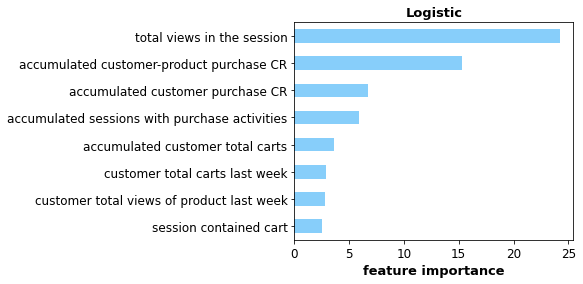

In [63]:
plot_feature_importance(df_fim_logistic, 'Logistic', 'logistic')

#### Section 3.2.2  Ridge classifier <a class="anchor" id="section_3_2_2"></a> 


In [64]:
%%time
clfr = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', RidgeClassifierCV(class_weight='balanced'))])
                       ('classifier', RidgeClassifier(class_weight='balanced'))])

clfr.fit(X_train, y_train)

y_pred = clfr.predict(X_test)

print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))
scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1 score': metrics.f1_score(y_test, y_pred),
          'roc auc': metrics.roc_auc_score(y_test, y_pred),
          'pr auc': metrics.average_precision_score(y_test, y_pred)}

score_metrics = pd.concat([score_metrics, pd.DataFrame(scores, index=['Ridge']).round(4)])
score_metrics


confusion matrix = 
 [[3738  339]
 [1037 3228]]
Wall time: 197 ms


,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.5939,0.8947,0.2331,0.3698,0.6022,0.6006
Ridge,0.8351,0.9050,0.7569,0.8243,0.8369,0.8092


In [65]:
df_fim_ridge = pd.DataFrame(clfr.named_steps['classifier'].coef_.T,
                            columns = ['feature importance'],
                            index = features).sort_values(by = 'feature importance', ascending = False)
df_fim_ridge

,feature importance
views,5.121808
r_up_sales_cumsum,3.953104
sale_sessions_cumsum,2.422359
r_u_sales_cumsum,1.493512
u_carts_cumsum,1.417300
up_views_last_1w,1.218429
r_up_carts_last_1w,1.016681
is_cart,0.792707
u_carts_last_1w,0.748126
up_carts_last_1w,0.451185


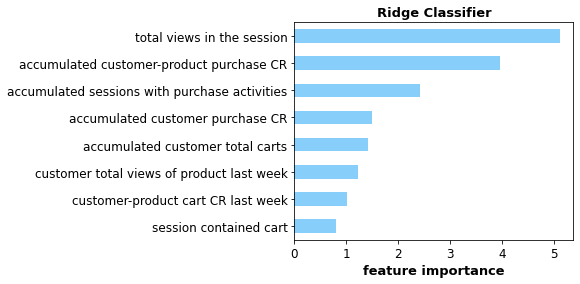

In [66]:
plot_feature_importance(df_fim_ridge, 'Ridge Classifier', 'ridge')

In [84]:
score_metrics.drop(index = 'xgboost', inplace=True)
score_metrics

,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.5939,0.8947,0.2331,0.3698,0.6022,0.6006
Ridge,0.8351,0.9050,0.7569,0.8243,0.8369,0.8092
Gradient boost,0.8354,0.9057,0.7569,0.8246,0.8372,0.8098


#### Section 3.2.3  Gradient boosting classifier <a class="anchor" id="section_3_2_3"></a> 


In [82]:
%%time
clfr = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', LinearSVC())])
#                       ('classifier', RandomForestClassifier(class_weight = {0:1,1:10}))])
                       ('classifier', GradientBoostingClassifier())])
#                       ('classifier', KNeighborsClassifier())])
#                       ('classifier', RandomForestClassifier(class_weight='balanced'))])
#                       ('classifier', RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=1))])
#                       ('classifier', DecisionTreeClassifier(class_weight='balanced'))])

clfr.fit(X_train, y_train)

y_pred = clfr.predict(X_test)

print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))
scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1 score': metrics.f1_score(y_test, y_pred),
          'roc auc': metrics.roc_auc_score(y_test, y_pred),
          'pr auc': metrics.average_precision_score(y_test, y_pred)}

pd.DataFrame(scores, index=['Gradient boost']).round(4)

score_metrics = pd.concat([score_metrics, pd.DataFrame(scores, index=['Gradient boost']).round(4)])
score_metrics


confusion matrix = 
 [[3741  336]
 [1037 3228]]
Wall time: 28.2 s


,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.5939,0.8947,0.2331,0.3698,0.6022,0.6006
Ridge,0.8351,0.9050,0.7569,0.8243,0.8369,0.8092
Gradient boost,0.8354,0.9057,0.7569,0.8246,0.8372,0.8098


#### Section 3.2.4  XG boost classifier <a class="anchor" id="section_3_2_4"></a> 


In [90]:
%%time
clfr = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', XGBClassifier(learning_rate=0.1, scale_pos_weight = 3.8))])
#                       ('classifier', XGBClassifier(learning_rate=0.1, scale_pos_weight = 1))])
                       ('classifier', XGBClassifier(learning_rate=0.005))])

clfr.fit(X_train, y_train)

y_pred = clfr.predict(X_test)

print('\nconfusion matrix = \n', metrics.confusion_matrix(y_test, y_pred))
scores = {'accuracy': metrics.accuracy_score(y_test, y_pred),
          'precision': metrics.precision_score(y_test, y_pred),
          'recall': metrics.recall_score(y_test, y_pred),
          'f1 score': metrics.f1_score(y_test, y_pred),
          'roc auc': metrics.roc_auc_score(y_test, y_pred),
          'pr auc': metrics.average_precision_score(y_test, y_pred)}

pd.DataFrame(scores, index=['xgboost']).round(4)

score_metrics = pd.concat([score_metrics, pd.DataFrame(scores, index=['xgboost']).round(4)])
score_metrics

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

confusion matrix = 
 [[3741  336]
 [1029 3236]]
Wall time: 3.95 s


,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.5939,0.8947,0.2331,0.3698,0.6022,0.6006
Ridge,0.8351,0.9050,0.7569,0.8243,0.8369,0.8092
Gradient boost,0.8354,0.9057,0.7569,0.8246,0.8372,0.8098
xgboost,0.8364,0.9059,0.7587,0.8258,0.8382,0.8107


In [92]:
xgb_dict = dict(zip(['f'+str(x) for x in np.arange(len(features))], features))

feature_important = clfr.named_steps['classifier'].get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

df_fim_xgboost = pd.DataFrame(data=values,
                              index=keys,
                              columns=["feature importance"]) \
                   .reset_index()

df_fim_xgboost['index'] = df_fim_xgboost['index'].map(xgb_dict)
#df_fim_xgboost.drop(columns=['index'], inplace = True)
df_fim_xgboost.set_index('index', inplace = True)
df_fim_xgboost.sort_values(by = "feature importance", ascending=False)
df_fim_xgboost[:10]

,feature importance
index,
r_up_sales_cumsum,1977.453573
is_cart,1548.656834
up_views_cumsum,388.048051
views,737.008123
r_u_sales_cumsum,194.357054
u_carts_cumsum,75.114791
r_u_carts_cumsum,112.660013
r_up_carts_cumsum,254.300067
u_revenue_cumsum,18.652964


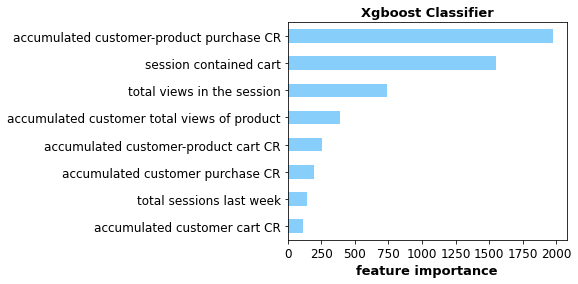

In [93]:
plot_feature_importance(df_fim_xgboost, 'Xgboost Classifier', 'xgb')

In [95]:
df_phone_org['revenue'].sum()/(2.672568784919999*1e9)

0.12515803725890387

### Section 3.3  Summary <a class="anchor" id="section_3_c"></a> 


In [97]:
score_metrics

,accuracy,precision,recall,f1 score,roc auc,pr auc
Logistic,0.5939,0.8947,0.2331,0.3698,0.6022,0.6006
Ridge,0.8351,0.9050,0.7569,0.8243,0.8369,0.8092
Gradient boost,0.8354,0.9057,0.7569,0.8246,0.8372,0.8098
xgboost,0.8364,0.9059,0.7587,0.8258,0.8382,0.8107


As the dataset is close to balanced, we use accuracy to evaluate the models. Except for logistic regression, the other three algorithms perform comparably, with XGboost model obtaining the highest accuracy of 83.6%. The next step to further improve model accuracy is collecting more customer information and encoding into useful features.